# **Credit Risk Cleaning Data**
This notebook cleans and preprocesses all the data from the files of the "Encuestas Financieras de las Familias".

The process consist in merging the different tables using the most meaningful data and solving the gaps generated by the different structures of the data obtained in the 2017 surve realized by the spanish central bank.

# **Install required packages**

In [ ]:
!pip install numpy
!pip install plotly
!pip install requests
!pip install PyPDF2
!pip install leap_ec
!pip install torch
!pip install scikit-learn

# **Imports**


In [1591]:
import pandas as pd
import numpy as np
import seaborn as sn
import matplotlib.pyplot as plt
import torch
import sklearn
import os

# **URL of the dataset**
All the datasets are in the "eff" folder of my github repository

In [1592]:
#2017
url_dataset_2017 = 'https://raw.githubusercontent.com/simoncraf/tfg/main/eff/2017/5/otras_secciones_2017_imp5.csv'
df = pd.read_csv(url_dataset_2017, sep = ';')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6413 entries, 0 to 6412
Columns: 1283 entries, h_2017 to mrenthog
dtypes: float64(1181), int64(102)
memory usage: 62.8 MB


# **Legend**

In [1593]:
###############################################################################
#DATOS MIEMBROS:
#p1_1_X -> Sexo del miembro X
#p1_2d_X -> Edad del miembro X
#p1_4_X -> Estado civil del miembro X
#p1_5_X -> Mayor nivel de formacion alcanzado del miembro X

#VIVIENDA PRINCIPAL:
#p2_5 -> Valor actual de la vivienda

#PRESTAMOS PARA LA COMPRA DE LA VIVIENDA PRINCIPAL:
#p2_12_X -> Importe pendiente de amortizar del prestamo X
#p2_13_X -> Tipo de interes anual del prestamo X
#p2_17_X -> Plazo pendiente del prestamo X 
#p2_18_X -> Importe mensual del prestamo X

#ALQUILER:
#p2_31 -> Importe mensual del alquiler de su vivienda

#OTRAS PROPIEDADES:
#p2_55_4 -> Importe pendiente de amortizar del prestamo de todas las propiedades
#p2_61_4 -> Importe mensual que paga del prestamo de todas las propiedades

#VEHICULOS:
#(Juntar variable de automoviles con la de otros vehículos)
#p2_72 -> Automoviles
#p2_76 -> Otros vehículos

#OTROS PRESTAMOS:
#Juntar variables
#p3_10_X -> Plazo pendiente hasta el vencimiento del prestamo X
#p3_11_X -> Importe mensual para el pago del prestamo X

#INVERSIONES:
#p4_24 -> Valor de la cartera de acciones y participaciones no cotizadas 
#p4_25 -> Ingresos anuales por dividendos de acciones y participaciones no cotizadas en bolsa
#p4_15 -> Valor de la cartera de acciones cotizadas
#p4_16 -> Ingresos anuales por dividendos de acciones cotizadas
#p4_28a -> Valor total de la cartera en fondos de inversión
#p4_35 -> Valor de cartera en valores de renta fija
#p4_40 -> Ingresos anuales proporcionados por otros activos financieros

#AHORRO:
#p4_7_1 -> Saldo total de la cuenta de ahorro
#p4_7_3 -> Saldo total cuentas utilizables para pagos

#PLANES DE PENSIONES:
#p5_4_X -> Edad a la que prevee percibir el plan de pensiones X
#p5_6_X -> Importe de la aportación anual al plan de pensiones X
#p5_7_X -> Valor actualizado del patrimonio en el plan de pensiones X

#DEUDAS TARJETAS DE CREDITO:
#p8_5a -> Importe que debe actualmente de deudas de tarjetas de credito
#p8_5b -> Importe que abona al mes para pagar deudas de tarjetas de credito

#GASTOS:
#p9_1 -> Gasto medio total en bienes de consumo en un mes
#p9_6 -> Gastos totales en el futuro seran mayores, menores o iguales

#RANDOM:
#p9_15a -> Porcentaje que gastaría en los próximos 12 meses si ganara un sorteo

#PREDICT:
#p9_11 -> Riesgo financiero dispuesto a correr cuando ahorran o invierten (1-4) (PREDICT)
###############################################################################

First I select the useful fields for the final goal and save them in a new dataframe 

In [1594]:
df2 = df[['h_2017','p1_1_1',
          'p1_2d_1',
          'p1_4_1',
          'p1_5_1',
          'p2_1','p2_5','p2_8',
          'p2_12_1','p2_12_2','p2_12_3','p2_12_4',
          'p2_13_1','p2_13_2','p2_13_3','p2_13_4',
          'p2_17_1','p2_17_2','p2_17_3','p2_17_4',
          'p2_18_1','p2_18_2','p2_18_3','p2_18_4',
          'p2_31','p2_32',
          'p2_55_4','p2_61_4',
          'p3_6_1','p3_6_2','p3_6_3','p3_6_4','p3_6_5','p3_6_6','p3_6_7','p3_6_8',
          'p3_10_1','p3_10_2','p3_10_3','p3_10_4','p3_10_5','p3_10_6','p3_10_7','p3_10_8',
          'p3_11_1','p3_11_2','p3_11_3','p3_11_4','p3_11_5','p3_11_6','p3_11_7','p3_11_8',
          'p4_24','p4_25','p4_15','p4_16','p4_28a','p4_3','p4_33','p4_35','p4_39','p4_40','p4_5',
          'p4_7_1','p4_7_3','p4_10','p4_18','p4_27','p5_1',
          'p5_4_1','p5_4_2','p5_4_3','p5_4_4','p5_4_5','p5_4_6','p5_4_7','p5_4_8','p5_4_9','p5_4_10',
          'p5_5b_1','p5_5b_2','p5_5b_3','p5_5b_4','p5_5b_5','p5_5b_6','p5_5b_7','p5_5b_8','p5_5b_9','p5_5b_10',
          'p5_6_1','p5_6_2','p5_6_3','p5_6_4','p5_6_5','p5_6_6','p5_6_7','p5_6_8','p5_6_9','p5_6_10',
          'p5_7_1','p5_7_2','p5_7_3','p5_7_4','p5_7_5','p5_7_6','p5_7_7','p5_7_8','p5_7_9','p5_7_10',
          'p9_1','p9_6',
          'p9_15a',
          'p9_11'
         ]].copy()

# **Cleaning the data**
To begin with, the data must be preprocessed to make it more digestible for the model. I'll start by joining columns that contain values from similar categories to reduce the dimensions as well. In general, it should be remembered that for the entire dataset, in binary response questions, 1 represents 'Yes' and 2 'No'. In addition -1 usually represents 'Does not know' and -2 'Does not answer'

# **Main residence**
Correct the NaN values regarding rent and mortgage, because if they rent a flat they don't have a mortgage and vice versa

In [1595]:
#Columns for mortgages
columns_loans = ['p2_12_1','p2_12_2','p2_12_3','p2_12_4','p2_13_1','p2_13_2','p2_13_3','p2_13_4',
                 'p2_17_1','p2_17_2','p2_17_3','p2_17_4','p2_18_1','p2_18_2','p2_18_3','p2_18_4']

#Columns for rents
columns_rents = 'p2_31'
'''
p2_1: Régimen de tenencia de la vivienda principal
1 -> Alquiler
2 -> Propiedad
3 -> Cesión gratuita
'''
df2.loc[df2['p2_1'] != 1, columns_rents] = 0
df2.loc[df2['p2_1'] != 2, ['p2_8','p2_5']] = 0 #Indica que tant el valor de la casa on viu com les hipoteques son 0
df2.loc[df2['p2_1'] != 2, columns_loans] = 0

'''
p2_8 -> Indica si te alguna hipoteca
'''
df2.loc[df2['p2_8'] == 2, columns_loans] = 0

#Main Residence
#Amounts outstanding to be repaid from all loans for the main home
df2['loans_tot_rest'] = df2[['p2_12_1','p2_12_2','p2_12_3','p2_12_4']].sum(axis = 1)
df2 = df2.drop(columns=['p2_12_1','p2_12_2','p2_12_3','p2_12_4'])

#Average annual interest rate on loans
df2['avg_loans_int'] = df2[['p2_13_1','p2_13_2','p2_13_3','p2_13_4']].agg('mean',axis = 1)
df2 = df2.drop(columns=['p2_13_1','p2_13_2','p2_13_3','p2_13_4'])

#Average outstanding term of loans
df2['avg_time_loans_rest'] = df2[['p2_17_1','p2_17_2','p2_17_3','p2_17_4']].agg('mean',axis = 1)
df2 = df2.drop(columns=['p2_17_1','p2_17_2','p2_17_3','p2_17_4'])

#Total monthly amount allocated to loans for the first home
df2['loans_tot_monthly'] = df2[['p2_18_1','p2_18_2','p2_18_3','p2_18_4']].sum(axis = 1)
df2 = df2.drop(columns=['p2_18_1','p2_18_2','p2_18_3','p2_18_4'])

df2.loc[df2['loans_tot_rest'] == 0.0, ['avg_loans_int','avg_time_loans_rest','loans_tot_monthly']] = 0

df2[['loans_tot_rest','avg_loans_int','avg_time_loans_rest','loans_tot_monthly']]

,loans_tot_rest,avg_loans_int,avg_time_loans_rest,loans_tot_monthly
0,0.0,0.00,0.0,0.0
1,0.0,0.00,0.0,0.0
2,0.0,0.00,0.0,0.0
3,0.0,0.00,0.0,0.0
4,0.0,0.00,0.0,0.0
...,...,...,...,...
6408,31539.0,1.65,9.0,318.0
6409,0.0,0.00,0.0,0.0
6410,250000.0,0.92,29.0,1500.0
6411,0.0,0.00,0.0,0.0


# **Other loans**

In [1596]:
#OTHER LOANS
#Total amount of the other loans
df2['other_loans_tot_rest'] = df2[['p3_6_1','p3_6_2','p3_6_3','p3_6_4','p3_6_5','p3_6_6','p3_6_7','p3_6_8']].sum(axis = 1)
df2 = df2.drop(columns=['p3_6_1','p3_6_2','p3_6_3','p3_6_4','p3_6_5','p3_6_6','p3_6_7','p3_6_8'])

#Average outstanding term of other loans
df2['other_loans_avg_time_rest'] = df2[['p3_10_1','p3_10_2','p3_10_3','p3_10_4','p3_10_5','p3_10_6','p3_10_7','p3_10_8']].agg('mean',axis = 1)
df2 = df2.drop(columns=['p3_10_1','p3_10_2','p3_10_3','p3_10_4','p3_10_5','p3_10_6','p3_10_7','p3_10_8'])

#Total monthly amount allocated to other loans
df2['other_loans_tot_monthly'] = df2[['p3_11_1','p3_11_2','p3_11_3','p3_11_4','p3_11_5','p3_11_6','p3_11_7','p3_11_8']].sum(axis = 1)
df2 = df2.drop(columns=['p3_11_1','p3_11_2','p3_11_3','p3_11_4','p3_11_5','p3_11_6','p3_11_7','p3_11_8'])

df2.loc[df2['other_loans_tot_rest'] == 0, ['other_loans_avg_time_rest','other_loans_tot_monthly']] = 0

df2[['other_loans_tot_rest','other_loans_tot_monthly','other_loans_avg_time_rest']]

,other_loans_tot_rest,other_loans_tot_monthly,other_loans_avg_time_rest
0,0.0,0.0,0.0
1,0.0,0.0,0.0
2,0.0,0.0,0.0
3,0.0,0.0,0.0
4,0.0,0.0,0.0
...,...,...,...
6408,0.0,0.0,0.0
6409,0.0,0.0,0.0
6410,0.0,0.0,0.0
6411,8000.0,114.0,4.0


# **Retirment plans**
We have to take the pension plans only from the main member of the survey since it is the one for which we have all the data. In addition, it must be taken into account that there may be negative values in some cases, for example in the question "At what age do you intend to collect your pension plan?" the value -3 is equivalent to that they do not want to collect it since they prefer to leave it as an inheritance.

In [1597]:
columns_retirement = ['p5_4_1','p5_4_2','p5_4_3','p5_4_4','p5_4_5','p5_4_6','p5_4_7','p5_4_8','p5_4_9','p5_4_10',
                     'p5_6_1','p5_6_2','p5_6_3','p5_6_4','p5_6_5','p5_6_6','p5_6_7','p5_6_8','p5_6_9','p5_6_10',
                      'p5_7_1','p5_7_2','p5_7_3','p5_7_4','p5_7_5','p5_7_6','p5_7_7','p5_7_8','p5_7_9','p5_7_10']
columns_age_retirement = ['p5_4_1','p5_4_2','p5_4_3','p5_4_4','p5_4_5','p5_4_6','p5_4_7','p5_4_8','p5_4_9','p5_4_10']
columns_retirement_plans = ['p5_5b_1','p5_5b_2','p5_5b_3','p5_5b_4','p5_5b_5','p5_5b_6','p5_5b_7','p5_5b_8','p5_5b_9','p5_5b_10']
columns_annual_ammount = ['p5_6_1','p5_6_2','p5_6_3','p5_6_4','p5_6_5','p5_6_6','p5_6_7','p5_6_8','p5_6_9','p5_6_10']
columns_plan_value = ['p5_7_1','p5_7_2','p5_7_3','p5_7_4','p5_7_5','p5_7_6','p5_7_7','p5_7_8','p5_7_9','p5_7_10']

'''
p5_1 -> Has retirement plan? 
1 -> Yes
2 -> No
'''

df2.loc[df2['p5_1'] == 2, columns_retirement] = 0

'''
At what age do you intend to collect your pension plan?
-1 -> No answer/ Do not know
-3 -> Do not want to collect it since they prefer to leave it as an inheritance.
'''
for age in columns_age_retirement:
    df2.loc[df2[age] == -3, age] = 100
    df2.loc[df2[age] == -1, age] = np.NaN
    

In [1598]:
#Delete pension plans that do not belong to the main member of the survey
'''
p5_5b_X -> Miembro al que pertenece el plan de pensiones X
p5_6_X -> Importe anual al plan de pensiones X
p5_7_X -> Valor actualizado del plan
'''

for idx, plan in enumerate(columns_retirement_plans):
    df2.loc[df2[plan] != 1, columns_age_retirement[idx]] = np.NaN
    df2.loc[df2[plan] != 1, columns_annual_ammount[idx]] = np.NaN
    df2.loc[df2[plan] != 1, columns_plan_value[idx]] = np.NaN
    
#We check that it is ok so the max value for every retirement plan that belongs to a member that is not the member 1, is NaN.
for idx, plan in enumerate(columns_retirement_plans):
    print(df2[[plan,columns_age_retirement[idx],columns_annual_ammount[idx],columns_plan_value[idx]]].loc[df2[plan] != 1].max())
    print('\n')

p5_5b_1    4.0
p5_4_1     NaN
p5_6_1     NaN
p5_7_1     NaN
dtype: float64


p5_5b_2    4.0
p5_4_2     NaN
p5_6_2     NaN
p5_7_2     NaN
dtype: float64


p5_5b_3    4.0
p5_4_3     NaN
p5_6_3     NaN
p5_7_3     NaN
dtype: float64


p5_5b_4    4.0
p5_4_4     NaN
p5_6_4     NaN
p5_7_4     NaN
dtype: float64


p5_5b_5    5.0
p5_4_5     NaN
p5_6_5     NaN
p5_7_5     NaN
dtype: float64


p5_5b_6    4.0
p5_4_6     NaN
p5_6_6     NaN
p5_7_6     NaN
dtype: float64


p5_5b_7    4.0
p5_4_7     NaN
p5_6_7     NaN
p5_7_7     NaN
dtype: float64


p5_5b_8    2.0
p5_4_8     NaN
p5_6_8     NaN
p5_7_8     NaN
dtype: float64


p5_5b_9    2.0
p5_4_9     NaN
p5_6_9     NaN
p5_7_9     NaN
dtype: float64


p5_5b_10    2.0
p5_4_10     NaN
p5_6_10     NaN
p5_7_10     NaN
dtype: float64




In [1599]:
#PENSION PLANS: Putting values together

#Average age at which you expect to receive the pension plan X
df2['avg_age_retirement_plans'] = df2[['p5_4_1','p5_4_2','p5_4_3','p5_4_4','p5_4_5','p5_4_6','p5_4_7','p5_4_8','p5_4_9','p5_4_10']].agg('mean',axis = 1)
df2 = df2.drop(columns=['p5_4_1','p5_4_2','p5_4_3','p5_4_4','p5_4_5','p5_4_6','p5_4_7','p5_4_8','p5_4_9','p5_4_10'])

#p5_6_X Amount of the annual contribution to the pension plan X
df2['tot_amm_year_retirement_plans'] = df2[['p5_6_1','p5_6_2','p5_6_3','p5_6_4','p5_6_5','p5_6_6','p5_6_7','p5_6_8','p5_6_9','p5_6_10']].agg('mean',axis = 1)
df2 = df2.drop(columns=['p5_6_1','p5_6_2','p5_6_3','p5_6_4','p5_6_5','p5_6_6','p5_6_7','p5_6_8','p5_6_9','p5_6_10'])

#p5_7_X -> Updated value of assets in the pension plan X
df2['tot_value_retirement_plans'] = df2[['p5_7_1','p5_7_2','p5_7_3','p5_7_4','p5_7_5','p5_7_6','p5_7_7','p5_7_8','p5_7_9','p5_7_10']].agg('mean',axis = 1)
df2 = df2.drop(columns=['p5_7_1','p5_7_2','p5_7_3','p5_7_4','p5_7_5','p5_7_6','p5_7_7','p5_7_8','p5_7_9','p5_7_10'])

df2[['avg_age_retirement_plans','tot_amm_year_retirement_plans','tot_value_retirement_plans']]

,avg_age_retirement_plans,tot_amm_year_retirement_plans,tot_value_retirement_plans
0,NaN,NaN,NaN
1,NaN,NaN,NaN
2,NaN,NaN,NaN
3,NaN,NaN,NaN
4,100.0,17500.0,150000.0
...,...,...,...
6408,65.0,250.0,1701.0
6409,65.0,8000.0,90000.0
6410,67.0,5300.0,40000.0
6411,NaN,NaN,NaN


# **Investments**
In a similar way to before, it is necessary to verify which conditions are met in order to assign values to cells with a null value.

In [1600]:
public_inv_columns = ['p4_15','p4_16']
no_pub_inv_columns = ['p4_24','p4_25']
investment_funds = 'p4_28a'
fix_rent = 'p4_35'
ann_income_oth_inv = 'p4_40'
saving_acc = 'p4_7_1'
pay_acc = 'p4_7_3'


df2.loc[df2['p4_10'] == 2, public_inv_columns] = 0
df2.loc[df2['p4_18'] == 2, no_pub_inv_columns] = 0
df2.loc[df2['p4_27'] == 2, investment_funds] = 0
df2.loc[df2['p4_33'] == 2, fix_rent] = 0
df2.loc[df2['p4_39'] == 2, ann_income_oth_inv] = 0
df2.loc[df2['p4_3'] == 2, saving_acc] = 0
df2.loc[df2['p4_5'] == 2, pay_acc] = 0

investments_columns = ['p4_15','p4_16','p4_24','p4_25','p4_28a','p4_35','p4_40','p4_7_1','p4_7_3']

In [1601]:
df2[investments_columns].isna().sum()

p4_15       0
p4_16       0
p4_24       0
p4_25       0
p4_28a    393
p4_35       0
p4_40       0
p4_7_1     11
p4_7_3     11
dtype: int64

In [1602]:
df2[['p4_27','p4_28a']].loc[df2['p4_28a'].isna()]

,p4_27,p4_28a
2,1,NaN
20,1,NaN
48,1,NaN
93,1,NaN
97,1,NaN
...,...,...
6326,1,NaN
6337,1,NaN
6343,1,NaN
6346,1,NaN


There are some rows that have an investment in an investment fund but they didn't specified the value. As they are few I will use the median to fill those values.

In [1603]:
'''
p4_27 -> Has investments in investment funds
p4_28a -> Value of those investments in investment funds
'''
median_inv_funds = df2['p4_28a'].loc[(df2['p4_27'] == 1) & (df2['p4_28a'].notna() == True)].median()
df2.loc[(df2['p4_27'] == 1) & (df2['p4_28a'].isna()), 'p4_28a'] = median_inv_funds

df2[['p4_27','p4_28a']].loc[df2['p4_27'] == 1]
print(median_inv_funds)
print(df2[['p4_27','p4_28a']].loc[df2['p4_27'] == 1].min())

160597.0
p4_27       1.0
p4_28a    212.0
dtype: float64


# **Section 6 Database**
The section 6 is a separated database that contains the answers of the survey regarding earnings. At first glance it seems that it has a large number of null values and therefore may be of little use to us, however this happens because many ways of obtaining profits are contemplated. For this reason I have decided to put it all together in a single variable, thus achieving a category that groups all the monthly income of a person. This category has non-null value for all rows.

In [1604]:
#Seccion 6 2017
url_dataset_seccion6_2017 = 'https://raw.githubusercontent.com/simoncraf/tfg/main/eff/2017/5/seccion6_2017_imp5.csv'
df_6 = pd.read_csv(url_dataset_seccion6_2017, sep = ';')

In [1605]:
df_6 =   df_6[['h_2017',
               'p6_14_1_1','p6_14_1_2','p6_14_1_3',
               'p6_102_1_1','p6_102_1_2','p6_102_1_3',
               'p6_49_1_1','p6_49_1_2','p6_49_1_3','p6_49_1_4',  
            ]].copy()
df_6.isna().sum()

h_2017           0
p6_14_1_1     4389
p6_14_1_2     6345
p6_14_1_3     6409
p6_102_1_1    6024
p6_102_1_2    6383
p6_102_1_3    6406
p6_49_1_1     3612
p6_49_1_2     5838
p6_49_1_3     6341
p6_49_1_4     6408
dtype: int64

In [1606]:
#p6_14_1_X -> Gross monthly salary
df_6['tot_income_month'] = df_6[['p6_14_1_1','p6_14_1_2','p6_14_1_3','p6_102_1_1','p6_102_1_2','p6_102_1_3','p6_49_1_1','p6_49_1_2','p6_49_1_3','p6_49_1_4']].sum(axis = 1)
df_6 = df_6.drop(columns=['p6_14_1_1','p6_14_1_2','p6_14_1_3','p6_102_1_1','p6_102_1_2','p6_102_1_3','p6_49_1_1','p6_49_1_2','p6_49_1_3','p6_49_1_4'])
print(df_6['tot_income_month'].isna().sum())
df_6

0


,h_2017,tot_income_month
0,1,637.0
1,2,1076.0
2,3,1000.0
3,4,2012.0
4,5,16667.0
...,...,...
6408,6409,2300.0
6409,6410,7422.0
6410,6411,41667.0
6411,6412,1840.0


# **Join the two Databases**

In [1661]:
df_2017 = df2.join(
    df_6.set_index(["h_2017"]),
    on=["h_2017"],
).copy()
df_2017 = df_2017.drop(columns = ['h_2017'])
df_2017

,p1_1_1,p1_2d_1,p1_4_1,p1_5_1,p2_1,p2_5,p2_8,p2_31,p2_32,p2_55_4,...,avg_loans_int,avg_time_loans_rest,loans_tot_monthly,other_loans_tot_rest,other_loans_avg_time_rest,other_loans_tot_monthly,avg_age_retirement_plans,tot_amm_year_retirement_plans,tot_value_retirement_plans,tot_income_month
0,2,73,6,2,2,150000.0,NaN,0.0,2,NaN,...,0.00,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,637.0
1,1,74,2,4,2,300000.0,NaN,0.0,1,NaN,...,0.00,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,1076.0
2,2,74,6,4,2,300000.0,NaN,0.0,1,NaN,...,0.00,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,1000.0
3,1,65,2,1002,2,124339.0,2.0,0.0,1,NaN,...,0.00,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,2012.0
4,1,76,2,2,2,311529.0,2.0,0.0,1,NaN,...,0.00,0.0,0.0,0.0,0.0,0.0,100.0,17500.0,150000.0,16667.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6408,2,45,4,1002,2,84000.0,1.0,0.0,2,NaN,...,1.65,9.0,318.0,0.0,0.0,0.0,65.0,250.0,1701.0,2300.0
6409,1,49,2,1002,2,1000000.0,NaN,0.0,1,NaN,...,0.00,0.0,0.0,0.0,0.0,0.0,65.0,8000.0,90000.0,7422.0
6410,1,47,2,1002,2,600000.0,1.0,0.0,1,NaN,...,0.92,29.0,1500.0,0.0,0.0,0.0,67.0,5300.0,40000.0,41667.0
6411,1,73,2,1001,2,150000.0,2.0,0.0,2,NaN,...,0.00,0.0,0.0,8000.0,4.0,114.0,NaN,NaN,NaN,1840.0


Lets rename the columns to be easier to read an interpretate and drop some columns that are not needed anymore

In [1662]:
df_2017 = df_2017.rename(columns={"p1_1_1":"gender",'p1_2d_1':'age','p1_4_1':'married','p1_5_1':'education',
                       'p2_5':'value_main_house','p2_31':'rent_monthly_cost','p2_55_4':'tot_amm_loans_rest',
                       'p2_61_4' : 'tot_month_loans','p4_24':'port_val_no_pub','p4_25':'ann_income_div_no_pub',
                       'p4_15':'port_val_pub','p4_10':'has_pub_stocks','p4_27':'has_inv_funds','p4_18':'has_no_pub_stocks',
                       'p5_1':'has_retirment_plan','p2_32':'has_oth_real_state','p4_33':'has_fix_rent_inv','p4_39':'has_oth_inv',
                       'p2_1':'possesion_main_house','p2_8':'has_loans_for_main_house','p4_3':'has_saving_acc','p4_5':'has_pay_acc',
                       'p4_16':'ann_income_div_pub', 'p4_28a':'port_val_inv_funds','p4_35':'port_val_fix_rent',
                       'p4_40':'ann_income_oth_inv','p4_7_1':'tot_amm_savings_acc','p4_7_3':'tot_amm_pay_acc',
                       'p9_1':'avg_month_expenses_goods',
                       'p9_6':'future_expenses','p9_15a':'%_spend_future_win','p9_11':'risk'})

df_2017 = df_2017.drop(columns = columns_retirement_plans)

Now it's time to fill the last NaN cells and group some variables to reduce dimensionality

In [1663]:
#Fill has_loans_for_main_house as it has many NaN values
df_2017.loc[df_2017['loans_tot_rest'] > 0, 'has_loans_for_main_house'] = 1
df_2017.loc[df_2017['loans_tot_rest'] <= 0, 'has_loans_for_main_house'] = 2

#Total loans rest
df_2017['tot_loans_rest'] = df_2017[['tot_amm_loans_rest','loans_tot_rest','other_loans_tot_rest']].sum(axis = 1)
df_2017 = df_2017.drop(columns=['tot_amm_loans_rest','loans_tot_rest','other_loans_tot_rest'])

#Total loans month
df_2017['tot_loans_month'] = df_2017[['tot_month_loans','other_loans_tot_monthly','loans_tot_monthly']].sum(axis = 1)
df_2017 = df_2017.drop(columns=['tot_month_loans','other_loans_tot_monthly','loans_tot_monthly'])

In [1664]:
#There are now very few NaN values so I fill them with the median
from sklearn.impute import SimpleImputer

imputer = SimpleImputer(strategy = 'median')
imputer.fit(df_2017)
x = imputer.transform(df_2017)
df_2017 = pd.DataFrame(x, columns = df_2017.columns, index = df_2017.index)
df_2017.isna().sum()

gender                           0
age                              0
married                          0
education                        0
possesion_main_house             0
value_main_house                 0
has_loans_for_main_house         0
rent_monthly_cost                0
has_oth_real_state               0
port_val_no_pub                  0
ann_income_div_no_pub            0
port_val_pub                     0
ann_income_div_pub               0
port_val_inv_funds               0
has_saving_acc                   0
has_fix_rent_inv                 0
port_val_fix_rent                0
has_oth_inv                      0
ann_income_oth_inv               0
has_pay_acc                      0
tot_amm_savings_acc              0
tot_amm_pay_acc                  0
has_pub_stocks                   0
has_no_pub_stocks                0
has_inv_funds                    0
has_retirment_plan               0
avg_month_expenses_goods         0
future_expenses                  0
%_spend_future_win  

Education variable has some big values (97, 1001 and 1002) for some of the answers, compared with the other answers that go in a range of 1 to 12, so to facilitate the normalization it's better to fix that.

In [1665]:
#Education:
'''
1 Analfabetos
2 Primaria
3 Enseñanza para la inserción laboral sin ESO
4 ESO
5 Enseñanza para la inserción laboral que precisa de ESO
6 Bachilleratoo
7 Enseñanza para la inserción laboral que precisa Bachillerato
8 Grado superior de Formación Profesional
9 Enseñanza de de 2 o más años que precisa bachiller
1001 Diplomados universitarios, ingenieros técnicos, arquitectos técnicos y equivalentes
1002 Grados universitarios, licenciados, ingenieros superiores, arquitectos y equivalentes
11 Master
12 Doctorado
97 Otro
'''
df_2017.loc[df_2017['education'] == 1001, 'education'] = 10
df_2017.loc[df_2017['education'] == 97, 'education'] = 14
df_2017.loc[df_2017['education'] == 12, 'education'] = 13
df_2017.loc[df_2017['education'] == 11, 'education'] = 12
df_2017.loc[df_2017['education'] == 1002, 'education'] = 11

It's time to delete fields that are not useful anymore

In [1666]:
columns_to_drop = ['has_pub_stocks','has_inv_funds','has_no_pub_stocks','has_retirment_plan','has_oth_real_state',
                   'has_fix_rent_inv','has_oth_inv','has_loans_for_main_house','has_saving_acc','has_pay_acc',
                   'possesion_main_house','avg_loans_int','avg_time_loans_rest','other_loans_avg_time_rest','avg_age_retirement_plans']
df_2017 = df_2017.drop(columns = columns_to_drop)

In orther to reduce dimensionality let's group some fields that have common meanings

In [1667]:
df_2017['tot_amm_acc'] = df_2017[['tot_amm_savings_acc','tot_amm_pay_acc']].sum(axis = 1)
df_2017 = df_2017.drop(columns = ['tot_amm_savings_acc','tot_amm_pay_acc'])
df_2017['port_inv_val'] = df_2017[['port_val_no_pub','port_val_fix_rent','port_val_pub','port_val_inv_funds']].sum(axis = 1)
df_2017 = df_2017.drop(columns = ['port_val_no_pub','port_val_fix_rent','port_val_pub','port_val_inv_funds'])
df_2017['ann_inv_income'] = df_2017[['ann_income_div_no_pub','ann_income_oth_inv','ann_income_div_pub']].sum(axis = 1)
df_2017 = df_2017.drop(columns = ['ann_income_div_no_pub','ann_income_oth_inv','ann_income_div_pub'])
df_2017['monthly_expenses'] =  df_2017[['rent_monthly_cost','tot_loans_month','avg_month_expenses_goods']].sum(axis = 1)
df_2017 = df_2017.drop(columns = ['rent_monthly_cost','tot_loans_month','avg_month_expenses_goods'])

In [1668]:
df_2017.max()

gender                                   2.0
age                                     85.0
married                                  6.0
education                               14.0
value_main_house                   7000000.0
future_expenses                          3.0
%_spend_future_win                     100.0
risk                                     4.0
tot_amm_year_retirement_plans        64000.0
tot_value_retirement_plans         1000000.0
tot_income_month                     90000.0
tot_loans_rest                     6689426.0
tot_amm_acc                       15000000.0
port_inv_val                     376000000.0
ann_inv_income                    12600000.0
monthly_expenses                     36442.0
dtype: float64

Finally to manage better the data lets standarize the money values as they are too big

In [1669]:
money_columns = ['value_main_house','tot_amm_year_retirement_plans','tot_value_retirement_plans','tot_income_month',
                'tot_loans_rest','tot_amm_acc','port_inv_val','ann_inv_income','monthly_expenses']

df_2017[money_columns] = df_2017[money_columns] / 1000

In [1670]:
df_2017.max()

gender                                2.000
age                                  85.000
married                               6.000
education                            14.000
value_main_house                   7000.000
future_expenses                       3.000
%_spend_future_win                  100.000
risk                                  4.000
tot_amm_year_retirement_plans        64.000
tot_value_retirement_plans         1000.000
tot_income_month                     90.000
tot_loans_rest                     6689.426
tot_amm_acc                       15000.000
port_inv_val                     376000.000
ann_inv_income                    12600.000
monthly_expenses                     36.442
dtype: float64

Now it's a good moment to check the linear correlation between variables. Correlationss go from -1 to 1, indicating a positive or negative correlation with the predicted variable. In this case we can see that there are not big linear correlations (-0.5 <, > 0.5), but that doesn't mean that our data is not related, but just that their connection is maybe more complex.

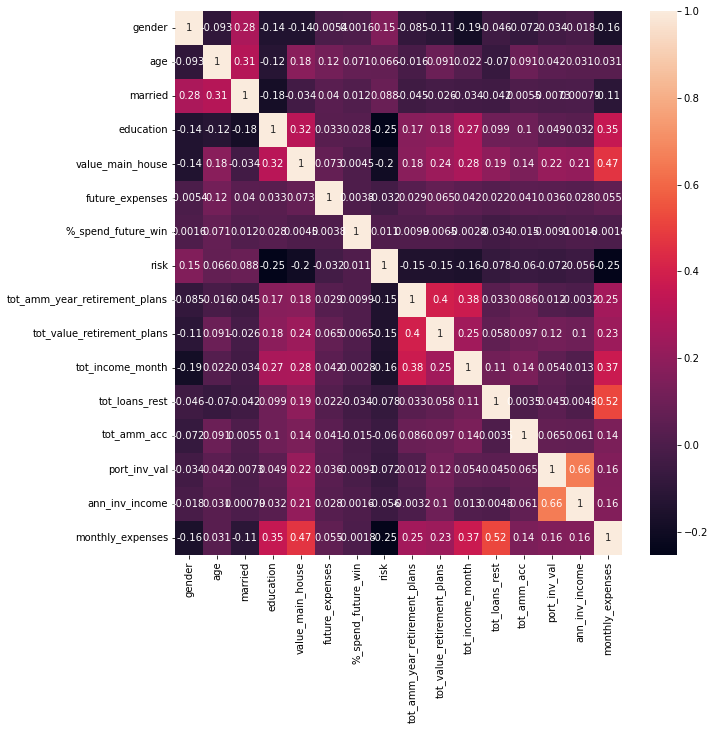

In [1671]:
corr = df_2017.corr()
#corr[['risk']].sort_values(by = ['risk'], ascending = False)
fig, ax = plt.subplots(figsize=(10,10)) 
sn.heatmap(corr, annot=True, ax = ax)
plt.show()

In [1672]:
df_2017.shape

(6413, 16)

In [1673]:
from sklearn.neighbors import LocalOutlierFactor

lof = LocalOutlierFactor()
df_2017_hat = lof.fit_predict(df_2017)
outlier = df_2017_hat != -1

df_outlier = pd.DataFrame(outlier, columns = ['Inlier'])
df_2017 = pd.merge(df_2017, df_outlier, left_index=True, right_index=True)

df_2017 = df_2017[df_2017.Inlier != False]
df_2017 = df_2017.drop(columns = ['Inlier'])

In [1683]:
df_2017.max()

gender                               2.0000
age                                 85.0000
married                              6.0000
education                           14.0000
value_main_house                  4000.0000
future_expenses                      3.0000
%_spend_future_win                 100.0000
risk                                 4.0000
tot_amm_year_retirement_plans       38.2305
tot_value_retirement_plans         550.0000
tot_income_month                    80.0000
tot_loans_rest                    2807.1910
tot_amm_acc                       1500.0000
port_inv_val                     12694.8690
ann_inv_income                    2000.0000
monthly_expenses                    23.4450
dtype: float64

Save the Dataframe for the next step

In [1684]:
os.makedirs('final_dataset', exist_ok=True)  
df_2017.to_csv('final_dataset/df_2017.csv', index = False)  